# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
num_campaigns = 52944 
num_campaigns

52944

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, classification_report, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn import set_config
from sklearn.inspection import permutation_importance

In [116]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
print(df.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

In [117]:
from tabulate import tabulate
tabulate(df.head(),headers = df.columns, tablefmt = 'psql')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Checking for duplicates and removing them

In [7]:
df.duplicated().sum()

12

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

#### There are many categorical features which need to be OneHot encoded

In [12]:
df['y'].value_counts()

y
no     36537
yes     4639
Name: count, dtype: int64

#### Removing `duration` as suggested by the data description

In [119]:
df = df.drop(columns=['duration'], axis=1)

#### Understanding data using plots

Text(0.5, 1.0, 'Campaign Vs y')

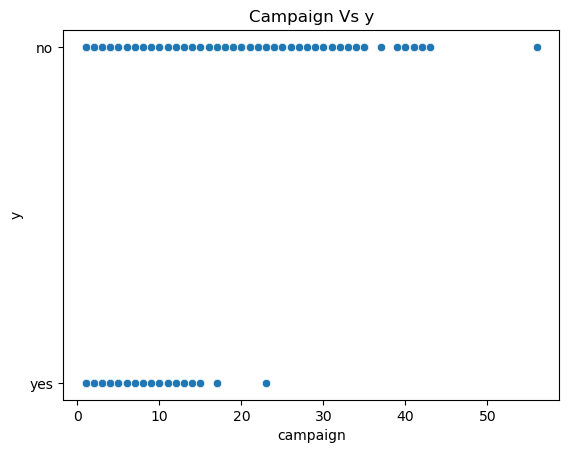

In [14]:
sns.scatterplot(data=df, x='campaign' , y='y')
plt.title('Campaign Vs y')

Text(0.5, 1.0, 'y Vs euribor3m')

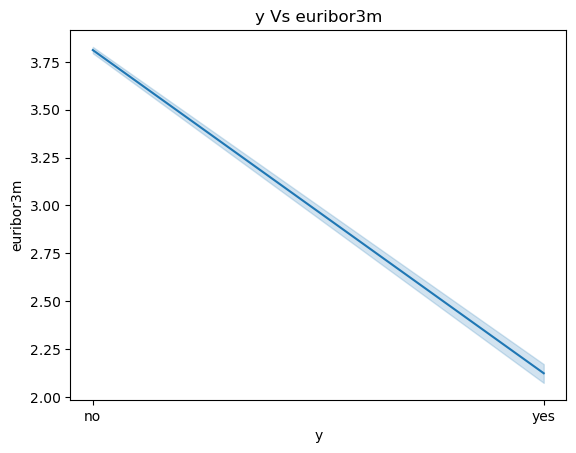

In [15]:
sns.lineplot(data=df, x='y', y='euribor3m')
plt.title('y Vs euribor3m')

Text(0.5, 1.0, 'Euribor3m Vs y')

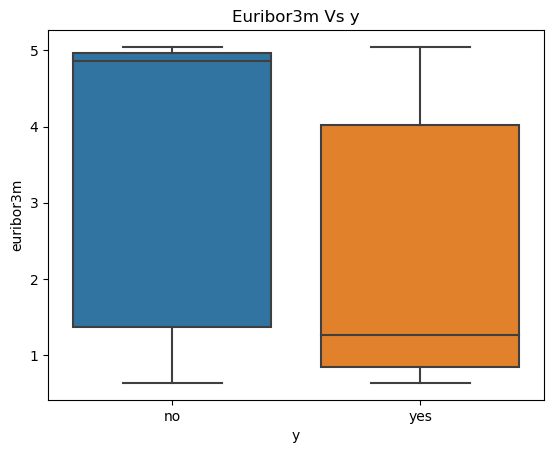

In [87]:
sns.boxplot(data=df, x='y', y='euribor3m')
plt.title('Euribor3m Vs y')

#### `campaign` and `euribor3m` seem to affect the target `y` a bit. `euribor3m` shows quite a bit of shift in the median

Text(0.5, 1.0, 'Month Vs y')

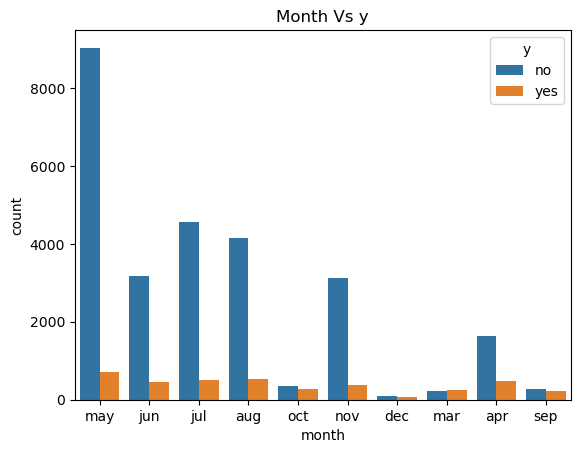

In [95]:
sns.countplot(data=df, x='month', hue='y')
plt.title('Month Vs y')

#### `month` does not show much correlation. Months of march, september, october, december have lower volume but they also show higher sign up rate.

Text(0.5, 1.0, 'y Vs age')

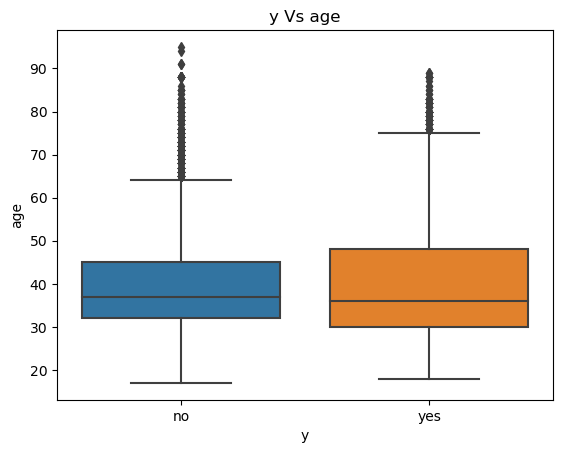

In [97]:
sns.boxplot(data=df, x='y', y='age')
plt.title('y Vs age')

#### Not much correlation between `age` and target `y`

Text(0.5, 1.0, 'y Vs cons.price.idx')

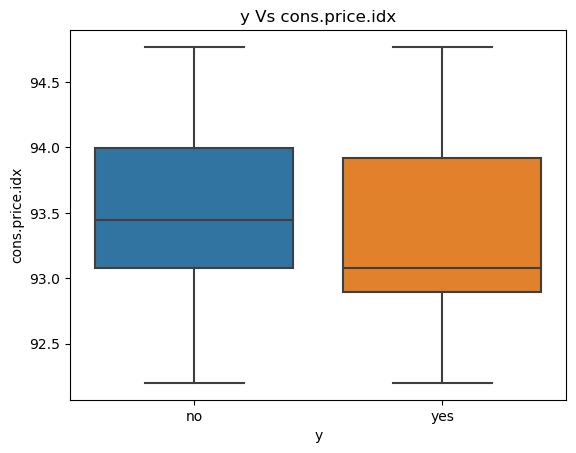

In [94]:
sns.boxplot(data=df, x='y', y='cons.price.idx')
plt.title('y Vs cons.price.idx')

Text(0.5, 1.0, 'y Vs cons.conf.idx')

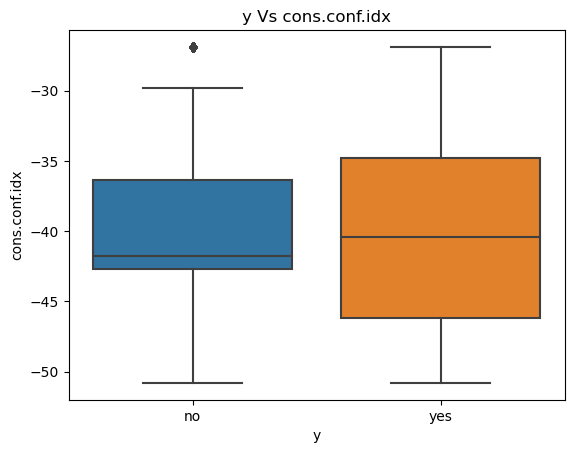

In [93]:
sns.boxplot(data=df, x='y', y='cons.conf.idx')
plt.title('y Vs cons.conf.idx')

#### Both the consumer price index and confidence index show some correlation. The median seems to shift with the target`y`

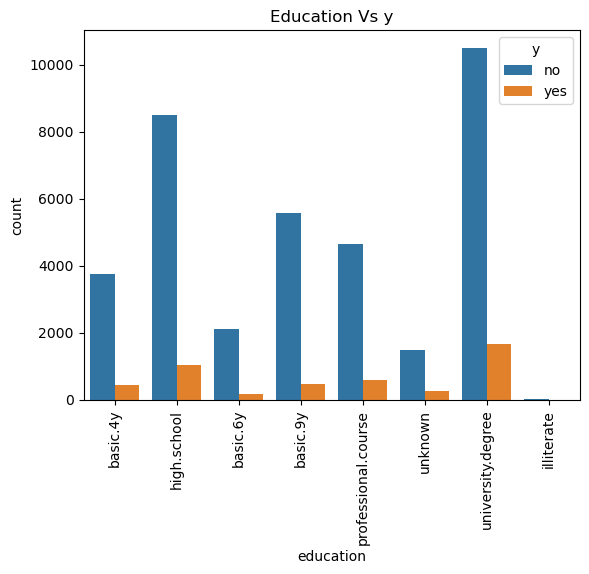

In [120]:
sns.countplot(data=df, x='education', hue='y')
plt.title('Education Vs y')
plt.xticks(rotation=90);

(array([0, 1, 2]),
 [Text(0, 0, 'married'), Text(1, 0, 'single'), Text(2, 0, 'divorced')])

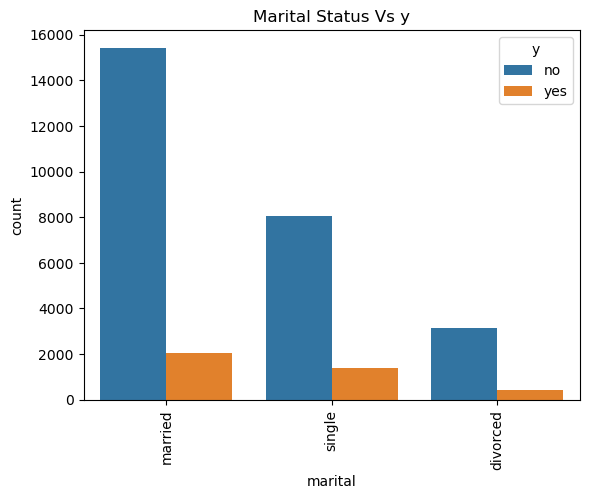

In [98]:
sns.countplot(data=df, x='marital', hue='y')
plt.title('Marital Status Vs y')
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'no'), Text(1, 0, 'yes')])

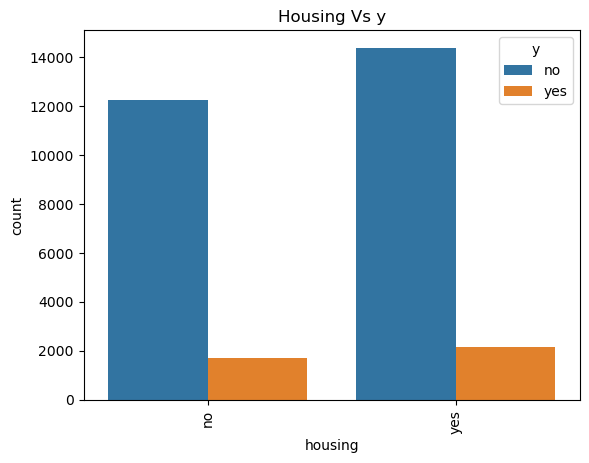

In [99]:
sns.countplot(data=df, x='housing', hue='y')
plt.title('Housing Vs y')
plt.xticks(rotation=90)

#### Not much correlation between `education` `marital` `housing` and the target `y`

Text(0.5, 1.0, 'y Vs emp.var.rate')

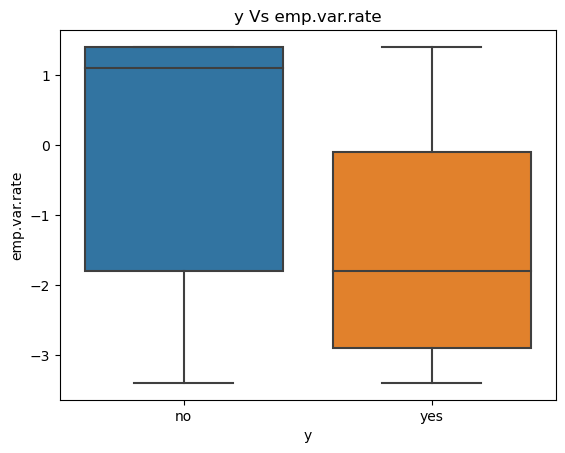

In [102]:
sns.boxplot(data=df, x='y', y='emp.var.rate')
plt.title('y Vs emp.var.rate')

#### Employment variance rate seems to shift quite a bit with the target `y`

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### OBJECTIVE

#### Based on inputs on customer, bank and campaign calls, predict if the customer is bound to sign up for term deposit. Compare classifiers and recommend the best one for the task.

#### Data Preparation

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  campaign        41176 non-null  int64  
 11  pdays           41176 non-null  int64  
 12  previous        41176 non-null  int64  
 13  poutcome        41176 non-null  object 
 14  emp.var.rate    41176 non-null  float64
 15  cons.price.idx  41176 non-null  float64
 16  cons.conf.idx   41176 non-null  float64
 17  euribor3m       41176 non-null  floa

In [24]:
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [26]:
for col in df.select_dtypes(include = 'object').columns:
    print(df[col].value_counts().to_markdown())

| job           |   count |
|:--------------|--------:|
| admin.        |   10419 |
| blue-collar   |    9253 |
| technician    |    6739 |
| services      |    3967 |
| management    |    2924 |
| retired       |    1718 |
| entrepreneur  |    1456 |
| self-employed |    1421 |
| housemaid     |    1060 |
| unemployed    |    1014 |
| student       |     875 |
| unknown       |     330 |
| marital   |   count |
|:----------|--------:|
| married   |   24921 |
| single    |   11564 |
| divorced  |    4611 |
| unknown   |      80 |
| education           |   count |
|:--------------------|--------:|
| university.degree   |   12164 |
| high.school         |    9512 |
| basic.9y            |    6045 |
| professional.course |    5240 |
| basic.4y            |    4176 |
| basic.6y            |    2291 |
| unknown             |    1730 |
| illiterate          |      18 |
| default   |   count |
|:----------|--------:|
| no        |   32577 |
| unknown   |    8596 |
| yes       |       3 |
| ho

#### Removing 'unknown' values in categorical columns

In [121]:
for col in df.select_dtypes(include = 'object').columns:
    cond = (df[col] == 'unknown')
    df[col] = np.where(cond, np.nan, df[col])
    print(df[col].value_counts().to_markdown())

| job           |   count |
|:--------------|--------:|
| admin.        |   10422 |
| blue-collar   |    9254 |
| technician    |    6743 |
| services      |    3969 |
| management    |    2924 |
| retired       |    1720 |
| entrepreneur  |    1456 |
| self-employed |    1421 |
| housemaid     |    1060 |
| unemployed    |    1014 |
| student       |     875 |
| marital   |   count |
|:----------|--------:|
| married   |   24928 |
| single    |   11568 |
| divorced  |    4612 |
| education           |   count |
|:--------------------|--------:|
| university.degree   |   12168 |
| high.school         |    9515 |
| basic.9y            |    6045 |
| professional.course |    5243 |
| basic.4y            |    4176 |
| basic.6y            |    2292 |
| illiterate          |      18 |
| default   |   count |
|:----------|--------:|
| no        |   32588 |
| yes       |       3 |
| housing   |   count |
|:----------|--------:|
| yes       |   21576 |
| no        |   18622 |
| loan   |   count

In [122]:
df = df.dropna()

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30488 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  campaign        30488 non-null  int64  
 11  pdays           30488 non-null  int64  
 12  previous        30488 non-null  int64  
 13  poutcome        30488 non-null  object 
 14  emp.var.rate    30488 non-null  float64
 15  cons.price.idx  30488 non-null  float64
 16  cons.conf.idx   30488 non-null  float64
 17  euribor3m       30488 non-null  floa

In [124]:
for col in df.select_dtypes(include = 'object').columns:
    print(df[col].value_counts())

job
admin.           8737
blue-collar      5675
technician       5473
services         2857
management       2311
retired          1216
self-employed    1092
entrepreneur     1089
unemployed        738
housemaid         690
student           610
Name: count, dtype: int64
marital
married     17492
single       9443
divorced     3553
Name: count, dtype: int64
education
university.degree      10412
high.school             7699
professional.course     4321
basic.9y                4276
basic.4y                2380
basic.6y                1389
illiterate                11
Name: count, dtype: int64
default
no     30485
yes        3
Name: count, dtype: int64
housing
yes    16521
no     13967
Name: count, dtype: int64
loan
no     25720
yes     4768
Name: count, dtype: int64
contact
cellular     20443
telephone    10045
Name: count, dtype: int64
month
may    9733
jul    5081
aug    4673
jun    3614
nov    3496
apr    2115
oct     642
sep     495
mar     482
dec     157
Name: count, dtype: int64


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [125]:
ohe = OneHotEncoder(drop = 'if_binary', sparse_output=False, handle_unknown="ignore")

ct = ColumnTransformer(transformers=[
    ("ohe", ohe, df.select_dtypes(include = 'object').columns)],
    remainder='passthrough', verbose_feature_names_out=False
)

ct.set_output(transform="pandas")
df_transformed = ct.fit_transform(df)
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30488 entries, 0 to 41187
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   job_admin.                     30488 non-null  float64
 1   job_blue-collar                30488 non-null  float64
 2   job_entrepreneur               30488 non-null  float64
 3   job_housemaid                  30488 non-null  float64
 4   job_management                 30488 non-null  float64
 5   job_retired                    30488 non-null  float64
 6   job_self-employed              30488 non-null  float64
 7   job_services                   30488 non-null  float64
 8   job_student                    30488 non-null  float64
 9   job_technician                 30488 non-null  float64
 10  job_unemployed                 30488 non-null  float64
 11  marital_divorced               30488 non-null  float64
 12  marital_married                30488 non-null  floa

In [126]:
for col in df_transformed.columns:
    print(df_transformed[col].value_counts())

job_admin.
0.0    21751
1.0     8737
Name: count, dtype: int64
job_blue-collar
0.0    24813
1.0     5675
Name: count, dtype: int64
job_entrepreneur
0.0    29399
1.0     1089
Name: count, dtype: int64
job_housemaid
0.0    29798
1.0      690
Name: count, dtype: int64
job_management
0.0    28177
1.0     2311
Name: count, dtype: int64
job_retired
0.0    29272
1.0     1216
Name: count, dtype: int64
job_self-employed
0.0    29396
1.0     1092
Name: count, dtype: int64
job_services
0.0    27631
1.0     2857
Name: count, dtype: int64
job_student
0.0    29878
1.0      610
Name: count, dtype: int64
job_technician
0.0    25015
1.0     5473
Name: count, dtype: int64
job_unemployed
0.0    29750
1.0      738
Name: count, dtype: int64
marital_divorced
0.0    26935
1.0     3553
Name: count, dtype: int64
marital_married
1.0    17492
0.0    12996
Name: count, dtype: int64
marital_single
0.0    21045
1.0     9443
Name: count, dtype: int64
education_basic.4y
0.0    28108
1.0     2380
Name: count, dtype: i

In [209]:
corr = df_transformed.corr()
print(corr['y_yes'])

job_admin.                       0.024025
job_blue-collar                 -0.067496
job_entrepreneur                -0.019582
job_housemaid                   -0.000223
job_management                  -0.002428
job_retired                      0.102376
job_self-employed               -0.003301
job_services                    -0.035077
job_student                      0.088617
job_technician                  -0.013300
job_unemployed                   0.020917
marital_divorced                -0.012211
marital_married                 -0.031525
marital_single                   0.042191
education_basic.4y               0.009102
education_basic.6y              -0.018834
education_basic.9y              -0.045803
education_high.school           -0.009195
education_illiterate             0.008351
education_professional.course   -0.002525
education_university.degree      0.046619
default_yes                     -0.003776
housing_yes                      0.010071
loan_yes                        -0

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [128]:
from sklearn.utils import shuffle
shuffled_data = shuffle(df_transformed, random_state=42)
X = df_transformed.drop(columns=['y_yes'], axis=1)
y = df_transformed['y_yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=22, shuffle=True, stratify=y)

In [129]:
X_train.shape

(24390, 52)

In [130]:
y_train.value_counts()

y_yes
0.0    21303
1.0     3087
Name: count, dtype: int64

In [131]:
X_test.shape

(6098, 52)

In [132]:
y_test.value_counts()

y_yes
0.0    5326
1.0     772
Name: count, dtype: int64

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [133]:
y.value_counts()

y_yes
0.0    26629
1.0     3859
Name: count, dtype: int64

#### Unbalanced dataset. If the baseline was to predict the majority class, we get zero recall score. Recall score for value 1 is very important for our classification problem. We want to correctly identify all candidates who will accept term deposit. DummyClassifier with stratified option would be a better baseline model even though the recall score is very less.

In [134]:
dummy_pipe = Pipeline([('scaler', StandardScaler()),
                      ('baseline', DummyClassifier(strategy='stratified',random_state=42))])
dummy_pipe.fit(X_train, y_train)
print(classification_report(y_test, dummy_pipe.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      5326
         1.0       0.13      0.12      0.12       772

    accuracy                           0.78      6098
   macro avg       0.50      0.50      0.50      6098
weighted avg       0.78      0.78      0.78      6098



Text(0.5, 1.0, 'Baseline ROC Curve')

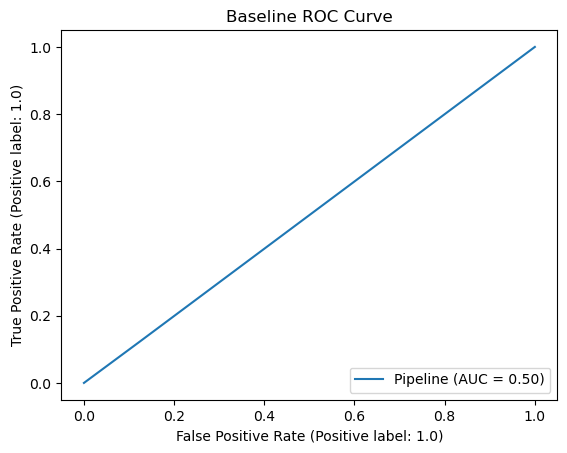

In [135]:
RocCurveDisplay.from_estimator(dummy_pipe, X_test, y_test)
plt.title('Baseline ROC Curve')

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [136]:
import time
lgr_pipe = Pipeline([('scaler', StandardScaler()),
                      ('lgr', LogisticRegression(random_state=42))])
start = time.time()
lgr_pipe.fit(X_train, y_train)
fit_time_lgr = time.time() - start

### Problem 9: Score the Model

What is the accuracy of your model?

In [137]:
report = classification_report(y_test, lgr_pipe.predict(X_test), output_dict=True)
recall_lgr = report['1.0']['recall']
pres_lgr = report['1.0']['precision']
recall_lgr

0.24481865284974094

In [138]:
train_acc_lgr= accuracy_score(y_train, lgr_pipe.predict(X_train))
test_acc_lgr = accuracy_score(y_test, lgr_pipe.predict(X_test))

In [139]:
print(train_acc_lgr, test_acc_lgr, recall_lgr, pres_lgr)

0.8891758917589175 0.8873401115119711 0.24481865284974094 0.6450511945392492


#### Definitely better than baseline but recall/precision needs to be improved further

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [140]:

svc_pipe = Pipeline([('scaler', StandardScaler()),
                    ('svc', SVC(probability=True))])
start = time.time()
svc_pipe.fit(X_train, y_train)
fit_time_svc = time.time() - start

In [141]:
report = classification_report(y_test, svc_pipe.predict(X_test), output_dict=True)
recall_svc = report['1.0']['recall']
pres_svc = report['1.0']['precision']
recall_svc

0.24481865284974094

In [142]:
train_acc_svc= accuracy_score(y_train, svc_pipe.predict(X_train))
test_acc_svc = accuracy_score(y_test, svc_pipe.predict(X_test))

In [143]:
dtree_pipe = Pipeline([('scaler', StandardScaler()),
                    ('dtree', DecisionTreeClassifier())])
start = time.time()
dtree_pipe.fit(X_train, y_train)
fit_time_dtree = time.time() - start

In [144]:
report = classification_report(y_test, dtree_pipe.predict(X_test), output_dict=True)
recall_dtree = report['1.0']['recall']
pres_dtree = report['1.0']['precision']
recall_dtree

0.34067357512953367

In [145]:
train_acc_dtree = accuracy_score(y_train, dtree_pipe.predict(X_train))
test_acc_dtree = accuracy_score(y_test, dtree_pipe.predict(X_test))

In [146]:
knn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())])
start = time.time()
knn_pipe.fit(X_train, y_train)
fit_time_knn = time.time() - start

In [147]:
report = classification_report(y_test, knn_pipe.predict(X_test), output_dict=True)
recall_knn = report['1.0']['recall']
pres_knn = report['1.0']['precision']
recall_knn

0.2849740932642487

In [148]:
train_acc_knn = accuracy_score(y_train, knn_pipe.predict(X_train))
test_acc_knn = accuracy_score(y_test, knn_pipe.predict(X_test))

In [149]:
models = ["LogisticRegression","KNN", "DecisionTrees", "SVM"]
train_times = [fit_time_lgr, fit_time_knn, fit_time_dtree, fit_time_svc]
train_acc = [train_acc_lgr, train_acc_knn, train_acc_dtree, train_acc_svc]
test_acc = [test_acc_lgr, test_acc_knn, test_acc_dtree, test_acc_svc]

model_cmp_table = pd.DataFrame({'Model':models, 'Train Time': train_times, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc})
model_cmp_table.set_index('Model')

,Train Time,Train Accuracy,Test Accuracy
Model,,,
LogisticRegression,0.064455,0.889176,0.887340
KNN,0.014327,0.903936,0.875041
DecisionTrees,0.108011,0.994629,0.824369
SVM,70.989730,0.902091,0.885864


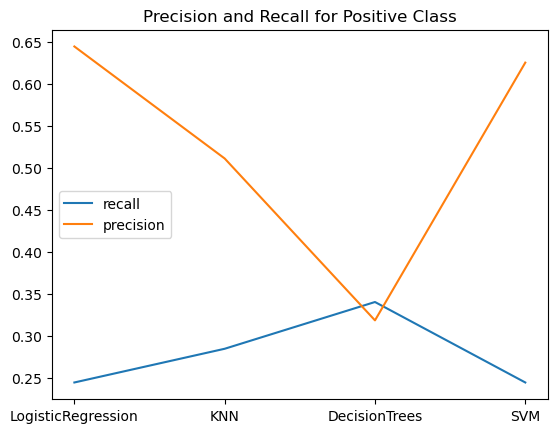

In [150]:
recall_pos = [recall_lgr, recall_knn, recall_dtree, recall_svc]
pres_pos = [pres_lgr, pres_knn, pres_dtree, pres_svc]
sns.lineplot(x=models, y=recall_pos, markers="o", label='recall')
sns.lineplot(x=models, y=pres_pos, label='precision')
plt.title('Precision and Recall for Positive Class')
plt.legend()

Text(0, 0.5, 'TruePositiveRate(Recall)')

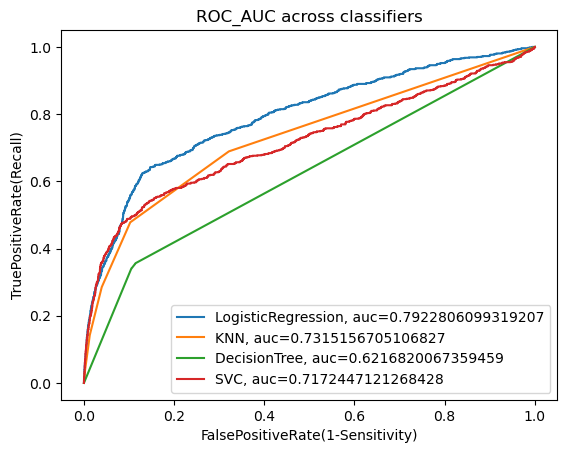

In [151]:
pred = lgr_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="LogisticRegression, auc="+str(auc))

pred = knn_pipe.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

pred = dtree_pipe.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

pred = svc_pipe.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="SVC, auc="+str(auc))
plt.legend(loc=0)
plt.title("ROC_AUC across classifiers")
plt.xlabel('FalsePositiveRate(1-Sensitivity)')
plt.ylabel('TruePositiveRate(Recall)')

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Finding feature importance with original columns

In [158]:
X_train_prepped = pd.DataFrame(StandardScaler().fit_transform(X_train))
X_test_prepped = pd.DataFrame(StandardScaler().fit_transform(X_test))
model = LogisticRegression(random_state=42)
model.fit(X_train_prepped, y_train)

LogisticRegression(random_state=42)

In [159]:
r = permutation_importance(model, X_test_prepped, y_test,
                            n_repeats=50,
                            random_state=0)

r.importances_mean

array([-1.67267957e-04,  2.00065595e-04, -3.27976386e-05,  2.62381109e-05,
       -1.63988193e-05, -3.27976386e-04,  1.63988193e-05, -4.59166940e-05,
        8.72417186e-04,  2.91898983e-04,  0.00000000e+00,  1.18071499e-04,
       -3.47654969e-04, -1.96785831e-05,  5.96917022e-04,  2.95178747e-05,
        5.37881273e-04, -6.88750410e-05,  1.63988193e-05, -3.83732371e-04,
        6.55952771e-05,  9.83929157e-06,  4.39488357e-04,  1.11511971e-04,
        3.59790095e-03,  3.31256150e-04,  2.32863234e-03,  7.21548049e-05,
        1.31190554e-05,  2.22367990e-03,  1.22663168e-03,  2.85339456e-04,
        6.46113480e-04, -2.00065595e-04,  2.52541817e-04, -3.24696622e-04,
        2.09904887e-04,  2.13184651e-04,  1.31190554e-04, -1.90226304e-04,
        4.39488357e-04, -4.36208593e-04,  2.12856674e-03,  4.85405051e-04,
        2.68940636e-04,  1.09445720e-02, -5.05083634e-04,  2.03046901e-01,
        8.64316169e-02,  1.61692358e-03,  4.65398491e-03,  2.53132174e-02])

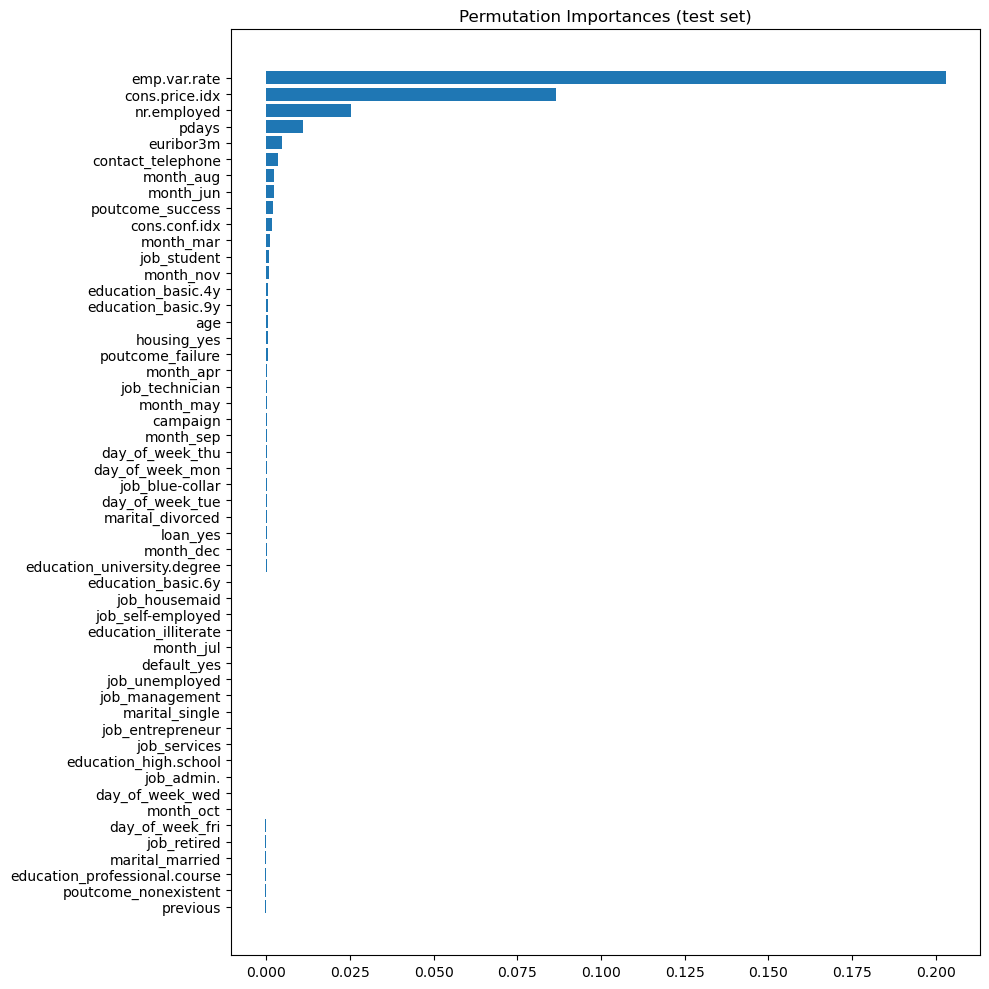

In [160]:
sorted_idx = r.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(X_train.columns[sorted_idx], r.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
fig.savefig('ImportanceForDegree1.png')
plt.show()

In [161]:
imp_cols = []
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         imp_cols.append(X_train.columns[i])
         print(f"{X_train.columns[i]:<8} --> "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

emp.var.rate --> 0.203 +/- 0.004
cons.price.idx --> 0.086 +/- 0.003
nr.employed --> 0.025 +/- 0.002
pdays    --> 0.011 +/- 0.001
euribor3m --> 0.005 +/- 0.001
contact_telephone --> 0.004 +/- 0.001
month_jun --> 0.002 +/- 0.001
poutcome_success --> 0.002 +/- 0.000
cons.conf.idx --> 0.002 +/- 0.001
job_student --> 0.001 +/- 0.000
education_basic.4y --> 0.001 +/- 0.000
education_basic.9y --> 0.001 +/- 0.000


#### Using only the most important columns

In [162]:

X_imp = shuffled_data[imp_cols]
y_imp = shuffled_data['y_yes']
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp,y_imp,test_size=0.2, random_state=22, shuffle=True, stratify=y_imp)

In [163]:
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24390 entries, 40531 to 37957
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   emp.var.rate        24390 non-null  float64
 1   cons.price.idx      24390 non-null  float64
 2   nr.employed         24390 non-null  float64
 3   pdays               24390 non-null  int64  
 4   euribor3m           24390 non-null  float64
 5   contact_telephone   24390 non-null  float64
 6   month_jun           24390 non-null  float64
 7   poutcome_success    24390 non-null  float64
 8   cons.conf.idx       24390 non-null  float64
 9   job_student         24390 non-null  float64
 10  education_basic.4y  24390 non-null  float64
 11  education_basic.9y  24390 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 2.4 MB


In [164]:
import time
lgr_pipe_imp = Pipeline([('scaler', StandardScaler()),
                      ('lgr', LogisticRegression(random_state=42))])
start = time.time()
lgr_pipe_imp.fit(X_train_imp, y_train_imp)
fit_time_lgr_imp = time.time() - start
y_pred = (lgr_pipe_imp.predict_proba(X_test_imp)[:,1] >= 0.3)
print(classification_report(y_test_imp, y_pred))
report = classification_report(y_test_imp, lgr_pipe_imp.predict(X_test_imp), output_dict=True)
recall_lgr_imp = report['1.0']['recall']
pres_lgr_imp = report['1.0']['precision']
train_acc_lgr_imp= accuracy_score(y_train_imp, lgr_pipe_imp.predict(X_train_imp))
test_acc_lgr_imp = accuracy_score(y_test_imp, lgr_pipe_imp.predict(X_test_imp))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93      5326
         1.0       0.48      0.43      0.45       772

    accuracy                           0.87      6098
   macro avg       0.70      0.68      0.69      6098
weighted avg       0.86      0.87      0.87      6098



In [165]:
knn_pipe_imp = Pipeline([('scaler', StandardScaler()),
                      ('knn', KNeighborsClassifier())])
start = time.time()
knn_pipe_imp.fit(X_train_imp, y_train_imp)
fit_time_knn_imp = time.time() - start
report = classification_report(y_test_imp, knn_pipe_imp.predict(X_test_imp), output_dict=True)
recall_knn_imp = report['1.0']['recall']
pres_knn_imp = report['1.0']['precision']
train_acc_knn_imp= accuracy_score(y_train_imp, knn_pipe_imp.predict(X_train_imp))
test_acc_knn_imp = accuracy_score(y_test_imp, knn_pipe_imp.predict(X_test_imp))

In [166]:
dtree_pipe_imp = Pipeline([('scaler', StandardScaler()),
                      ('dtree', DecisionTreeClassifier())])
start = time.time()
dtree_pipe_imp.fit(X_train_imp, y_train_imp)
fit_time_dtree_imp = time.time() - start
report = classification_report(y_test_imp, dtree_pipe_imp.predict(X_test_imp), output_dict=True)
recall_dtree_imp = report['1.0']['recall']
pres_dtree_imp = report['1.0']['precision']
train_acc_dtree_imp= accuracy_score(y_train_imp, dtree_pipe_imp.predict(X_train_imp))
test_acc_dtree_imp = accuracy_score(y_test_imp, dtree_pipe_imp.predict(X_test_imp))

In [167]:
svc_pipe_imp = Pipeline([('scaler', StandardScaler()),
                      ('svc', SVC())])
start = time.time()
svc_pipe_imp.fit(X_train_imp, y_train_imp)
fit_time_svc_imp = time.time() - start
report = classification_report(y_test_imp, svc_pipe_imp.predict(X_test_imp), output_dict=True)
recall_svc_imp = report['1.0']['recall']
pres_svc_imp = report['1.0']['precision']
train_acc_svc_imp= accuracy_score(y_train_imp, svc_pipe_imp.predict(X_train_imp))
test_acc_svc_imp = accuracy_score(y_test_imp, svc_pipe_imp.predict(X_test_imp))

In [168]:
models = ["LogisticRegression","KNN", "DecisionTrees", "SVM"]
train_times = [fit_time_lgr_imp, fit_time_knn_imp, fit_time_dtree_imp, fit_time_svc_imp]
train_acc = [train_acc_lgr_imp, train_acc_knn_imp, train_acc_dtree_imp, train_acc_svc_imp]
test_acc = [test_acc_lgr_imp, test_acc_knn_imp, test_acc_dtree_imp, test_acc_svc_imp]

model_cmp_table = pd.DataFrame({'Model':models, 'Train Time': train_times, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc})
model_cmp_table.set_index('Model')

,Train Time,Train Accuracy,Test Accuracy
Model,,,
LogisticRegression,0.046965,0.887905,0.887176
KNN,0.020572,0.894547,0.879633
DecisionTrees,0.018376,0.911931,0.879961
SVM,3.670807,0.888643,0.886028


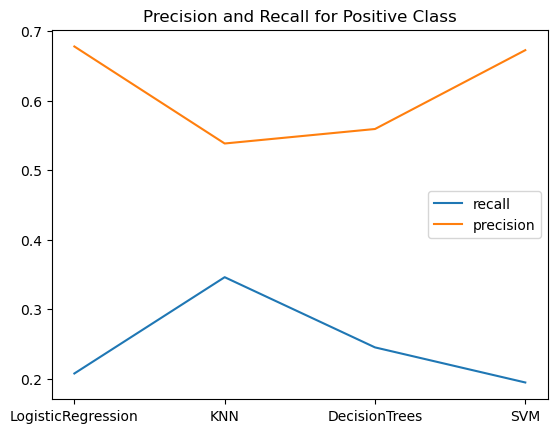

In [169]:
recall_pos = [recall_lgr_imp, recall_knn_imp, recall_dtree_imp, recall_svc_imp]
pres_pos = [pres_lgr_imp, pres_knn_imp, pres_dtree_imp, pres_svc_imp]
sns.lineplot(x=models, y=recall_pos, markers="o", label='recall')
sns.lineplot(x=models, y=pres_pos, label='precision')
plt.title('Precision and Recall for Positive Class')
plt.legend()

#### Logistic Regression with GridSearch

In [197]:
lgr_pipe = Pipeline([('scaler', StandardScaler()),
                     ('lgr', LogisticRegression(fit_intercept=True,random_state=42, max_iter=1000))])
params_to_try = {'lgr__C':np.logspace(0,10,50)}#, 'lgr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                #'lgr__penalty': ['l1', 'l2']} #uncommenting this takes a bit of time to run but produces same result
lgr_grid = GridSearchCV(estimator=lgr_pipe, cv=5, param_grid=params_to_try, scoring='recall')
start = time.time()
lgr_grid.fit(X_train_imp, y_train_imp)
fit_time_lgrgrid = time.time() - start
report = classification_report(y_test_imp, lgr_grid.best_estimator_.predict(X_test_imp), output_dict=True)
recall_lgrgrid_imp = report['1.0']['recall']
pres_lgrgrid_imp = report['1.0']['precision']
train_acc_lgrgrid_imp= accuracy_score(y_train_imp, lgr_grid.best_estimator_.predict(X_train_imp))
test_acc_lgrgrid_imp = accuracy_score(y_test_imp, lgr_grid.best_estimator_.predict(X_test_imp))

#### Decision Tree with GridSearch

In [199]:
dtree_pipe = Pipeline([('scaler', StandardScaler()),
                    ('dtree', DecisionTreeClassifier())])
params_to_try = {'dtree__max_depth': range(1,20),
         'dtree__min_samples_split': [2,5,10],
          'dtree__criterion': ['gini', 'entropy'],
          'dtree__min_samples_leaf': range(1,5)
         }
dtree_grid = GridSearchCV(estimator=dtree_pipe, cv=5, param_grid=params_to_try, scoring='recall')
start = time.time()
dtree_grid.fit(X_train_imp, y_train_imp)
fit_time_dtreegrid = time.time() - start
report = classification_report(y_test_imp, dtree_grid.best_estimator_.predict(X_test_imp), output_dict=True)
recall_dtreegrid_imp = report['1.0']['recall']
pres_dtreegrid_imp = report['1.0']['precision']
train_acc_dtreegrid_imp= accuracy_score(y_train_imp, dtree_grid.best_estimator_.predict(X_train_imp))
test_acc_dtreegrid_imp = accuracy_score(y_test_imp, dtree_grid.best_estimator_.predict(X_test_imp))

#### SVC

In [201]:
#only tried poly kernel here. Any kind of gridsearch takes forever
#params = {'model__kernel': ['poly'], 'model__gamma': [0.1, 1.0, 10.0]}
svc_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', SVC(coef0=1, probability=True, kernel='poly'))])
#svc_grid = HalvingRandomSearchCV(estimator=svc_pipe, param_distributions=params, cv=5, scoring='recall')
start = time.time()
svc_pipe.fit(X_train_imp, y_train_imp)
fit_time_svcpipe = time.time() - start
report = classification_report(y_test_imp, svc_pipe.predict(X_test_imp), output_dict=True)
recall_svcgrid_imp = report['1.0']['recall']
pres_svcgrid_imp = report['1.0']['precision']
train_acc_svcgrid_imp= accuracy_score(y_train_imp, svc_pipe.predict(X_train_imp))
test_acc_svcgrid_imp = accuracy_score(y_test_imp, svc_pipe.predict(X_test_imp))

#### KNN with GridSearch

In [203]:
knn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())])
params = {'knn__n_neighbors': [2,3,5,10,20,25,30,40]}#, 'knn__weights':['uniform', 'distance'],
         #'knn__metric': ['minowski', 'manhattan', 'cosine', 'l1', 'l2']}
knn_grid = GridSearchCV(estimator=knn_pipe, cv=5, param_grid = params, scoring='recall')
start= time.time()
knn_grid.fit(X_train_imp, y_train_imp)
fit_time_knngrid = time.time() - start
report = classification_report(y_test_imp, knn_grid.best_estimator_.predict(X_test_imp), output_dict=True)
recall_knngrid_imp = report['1.0']['recall']
pres_knngrid_imp = report['1.0']['precision']
train_acc_knngrid_imp= accuracy_score(y_train_imp, knn_grid.best_estimator_.predict(X_train_imp))
test_acc_knngrid_imp = accuracy_score(y_test_imp, knn_grid.best_estimator_.predict(X_test_imp))

In [208]:
models = ["LogisticRegression","KNN", "DecisionTrees", "SVM"]
train_times = [fit_time_lgrgrid, fit_time_knngrid, fit_time_dtreegrid, fit_time_svcpipe]
train_acc = [train_acc_lgrgrid_imp, train_acc_knngrid_imp, train_acc_dtreegrid_imp, train_acc_svcgrid_imp]
test_acc = [test_acc_lgrgrid_imp, test_acc_knngrid_imp, test_acc_dtreegrid_imp, test_acc_svcgrid_imp]
best_params = [lgr_grid.best_params_, knn_grid.best_params_, dtree_grid.best_params_, "{'kernel' = 'poly'}"]
model_cmp_table_grid = pd.DataFrame({'Model':models, "Best Params": best_params, 'Train Time' : train_times,'Train Accuracy': train_acc, 'Test Accuracy': test_acc})
model_cmp_table_grid.set_index('Model')
print(model_cmp_table_grid.to_markdown())

|    | Model              | Best Params                                                                                                          |   Train Time |   Train Accuracy |   Test Accuracy |
|---:|:-------------------|:---------------------------------------------------------------------------------------------------------------------|-------------:|-----------------:|----------------:|
|  0 | LogisticRegression | {'lgr__C': 1.0}                                                                                                      |      4.71485 |         0.887905 |        0.887176 |
|  1 | KNN                | {'knn__n_neighbors': 3}                                                                                              |     18.1078  |         0.891923 |        0.872745 |
|  2 | DecisionTrees      | {'dtree__criterion': 'entropy', 'dtree__max_depth': 9, 'dtree__min_samples_leaf': 4, 'dtree__min_samples_split': 10} |     31.0417  |         0.894301 |        0.885208 |
|  3 

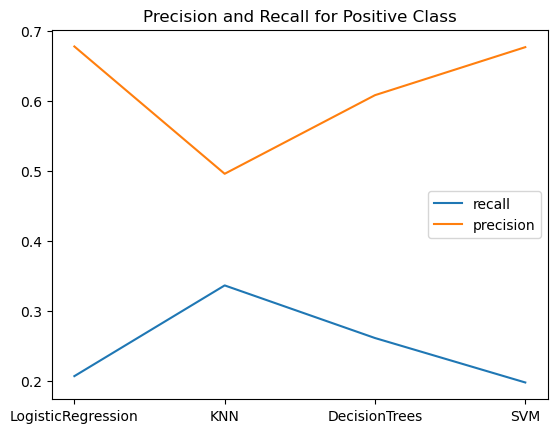

In [206]:
recall_pos = [recall_lgrgrid_imp, recall_knngrid_imp, recall_dtreegrid_imp, recall_svcgrid_imp]
pres_pos = [pres_lgrgrid_imp, pres_knngrid_imp, pres_dtreegrid_imp, pres_svcgrid_imp]
sns.lineplot(x=models, y=recall_pos, markers="o", label='recall')
sns.lineplot(x=models, y=pres_pos, label='precision')
plt.title('Precision and Recall for Positive Class')
plt.legend()

Text(0, 0.5, 'TruePositiveRate(Recall)')

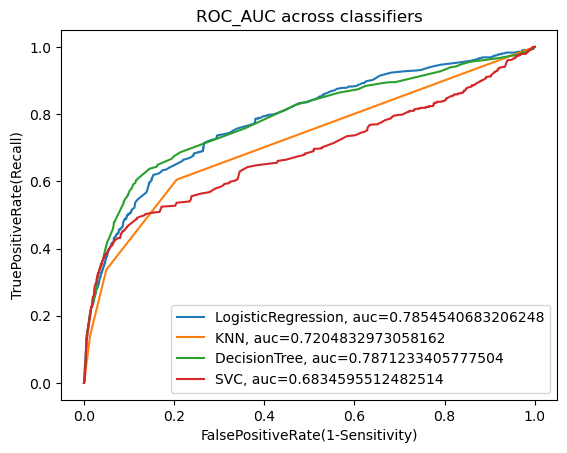

In [207]:
pred = lgr_grid.best_estimator_.predict_proba(X_test_imp)[:, 1]
fpr, tpr, thresh = roc_curve(y_test_imp, pred)
auc = roc_auc_score(y_test_imp, pred)
plt.plot(fpr,tpr,label="LogisticRegression, auc="+str(auc))

pred = knn_grid.best_estimator_.predict_proba(X_test_imp)[:,1]
fpr, tpr, thresh = roc_curve(y_test_imp, pred)
auc = roc_auc_score(y_test_imp, pred)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

pred = dtree_grid.best_estimator_.predict_proba(X_test_imp)[:,1]
fpr, tpr, thresh = roc_curve(y_test_imp, pred)
auc = roc_auc_score(y_test_imp, pred)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

pred = svc_pipe.predict_proba(X_test_imp)[:,1]
fpr, tpr, thresh = roc_curve(y_test_imp, pred)
auc = roc_auc_score(y_test_imp, pred)
plt.plot(fpr,tpr,label="SVC, auc="+str(auc))
plt.legend(loc=0)
plt.title("ROC_AUC across classifiers")
plt.xlabel('FalsePositiveRate(1-Sensitivity)')
plt.ylabel('TruePositiveRate(Recall)')

#### DecisionTree seems to have much improved AUC score compared to other classifiers

#### Feature Importance with Polynomial Features

In [184]:
poly_ordinal_ohe_2 = make_column_transformer((PolynomialFeatures(degree=2, include_bias=False), make_column_selector(dtype_include=np.number)),
                                            (StandardScaler(), make_column_selector(dtype_include=np.number)))

X_train_prepped_2 = pd.DataFrame(poly_ordinal_ohe_2.fit_transform(X_train_imp), columns= poly_ordinal_ohe_2.get_feature_names_out())
X_test_prepped_2 = pd.DataFrame(poly_ordinal_ohe_2.fit_transform(X_test_imp), columns= poly_ordinal_ohe_2.get_feature_names_out())

model_2 = LogisticRegression(max_iter=5000)
model_2.fit(X_train_prepped_2, y_train)

LogisticRegression(max_iter=5000)

In [185]:
r = permutation_importance(model_2, X_test_prepped_2, y_test,
                            n_repeats=30,
                            random_state=0)

r.importances_mean

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.88039794e-03,  1.63988193e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.69585656e-02,  3.66240297e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.70285339e-02,
        1.40647207e-02,  3.93571663e-04,  2.84246201e-04, -2.84246201e-04,
        1.09325462e-05,  7.27014322e-04, -3.11577566e-04,  1.14791735e-04,
        3.60774024e-04,  4.77041653e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.07718378e-04,  0.00000000e+00,
        0.00000000e+00,  

In [186]:
imp_cols_2 = []
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         imp_cols_2.append(poly_ordinal_ohe_2.get_feature_names_out()[i])
         print(f"{poly_ordinal_ohe_2.get_feature_names_out()[i]:<8} --> "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

polynomialfeatures__nr.employed^2 --> 0.087 +/- 0.003
polynomialfeatures__cons.price.idx nr.employed --> 0.057 +/- 0.003
polynomialfeatures__pdays^2 --> 0.048 +/- 0.002
polynomialfeatures__nr.employed pdays --> 0.014 +/- 0.001
polynomialfeatures__cons.price.idx pdays --> 0.000 +/- 0.000


In [187]:
X_train_imp_2 = X_train_prepped_2.copy()
X_test_imp_2 = X_test_prepped_2.copy()


In [192]:
dtree_pipe = Pipeline([('scaler', StandardScaler()),
                    ('dtree', DecisionTreeClassifier())])
params_to_try = {'dtree__max_depth': range(1,16),
         'dtree__min_samples_split': [2,5,10],
          'dtree__criterion': ['gini', 'entropy'],
          'dtree__min_samples_leaf': range(1,5)
         }
dtree_grid = GridSearchCV(estimator=dtree_pipe, cv=5, param_grid=params_to_try, scoring='recall')
start = time.time()
dtree_grid.fit(X_train_imp_2, y_train)
fit_time_poly_dtree = time.time() - start

In [193]:
fit_time_poly_dtree

118.83059525489807

In [194]:
y_pred = (dtree_grid.best_estimator_.predict_proba(X_test_imp_2)[:,1] >= 0.3)

In [195]:
print(classification_report(y_test_imp, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      5326
         1.0       0.46      0.58      0.51       772

    accuracy                           0.86      6098
   macro avg       0.70      0.74      0.72      6098
weighted avg       0.88      0.86      0.87      6098



Text(0.5, 1.0, 'ROC-AUC DecisionTree Poly Degree 2')

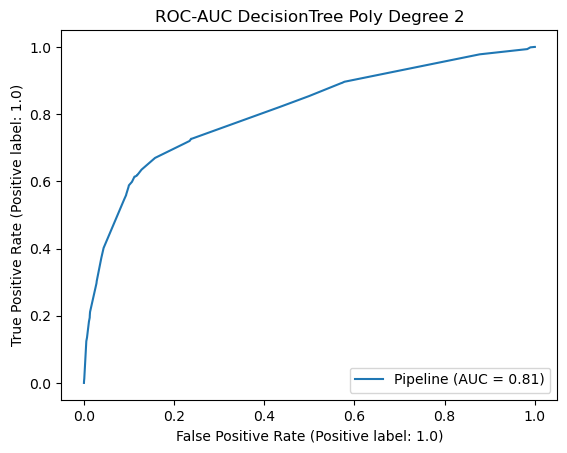

In [196]:
RocCurveDisplay.from_estimator(dtree_grid.best_estimator_, X_test_imp_2, y_test)
plt.title('ROC-AUC DecisionTree Poly Degree 2')

#### Using polynomial degree 2 on the top features shows some improvement from 0.79 to 0.81. Still the longer runtime might not be worth it. (31 to 118)

### Conclusion

#### DecisionTree and Logistic Regression seem to be good models for the task. Logistic Regression is much faster and did not even require much hyper parameter tuning.

##### Questions